In [2]:

!pip install xgboost flask joblib


In [3]:
# === STEP 2.1: LOAD YOUR DATA ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# LOAD YOUR CSV FILE HERE
df = pd.read_csv('crop Price forecaster.csv')
print(" YOUR CSV LOADED!")
print(f" Shape: {df.shape}")
print(f" Columns: {list(df.columns)}")
print("\n First 5 rows:")
print(df.head())


 YOUR CSV LOADED!
 Shape: (4660, 10)
 Columns: ['State', 'District', 'Market', 'Commodity', 'Variety', 'Grade', 'Arrival_Date', 'Min_x0020_Price', 'Max_x0020_Price', 'Modal_x0020_Price']

 First 5 rows:
        State      District                                 Market  \
0  Tamil Nadu         Karur           Karur(Uzhavar Sandhai ) APMC   
1  Tamil Nadu   Thirupathur     Vaniyampadi(Uzhavar Sandhai ) APMC   
2  Tamil Nadu  The Nilgiris  Udhagamandalam(Uzhavar Sandhai ) APMC   
3  Tamil Nadu     Cuddalore         Panruti(Uzhavar Sandhai ) APMC   
4  Tamil Nadu      Thirupur        Kangayam(Uzhavar Sandhai ) APMC   

     Commodity      Variety  Grade Arrival_Date  Min_x0020_Price  \
0  Onion Green  Onion Green  Local   29/12/2025             5500   
1  Onion Green  Onion Green  Local   29/12/2025             8000   
2  Onion Green  Onion Green  Local   29/12/2025             6000   
3  Onion Green  Onion Green  Local   29/12/2025             6000   
4  Onion Green  Onion Green  Local  

In [5]:
# === STEP 2.2: FIXED FEATURE ENGINEERING (NO ERRORS) ===
print("🔍 AUTO-DETECTING COLUMNS FROM YOUR CSV...")

# Auto-detect columns (safer)
price_col = next((col for col in df.columns if any(x in col.lower() for x in ['price', 'rate', 'modal'])), df.columns[-1])
date_col = next((col for col in df.columns if 'date' in col.lower()), None)
market_col = next((col for col in df.columns if any(x in col.lower() for x in ['market', 'mandi', 'apmc'])), None)
crop_col = next((col for col in df.columns if any(x in col.lower() for x in ['crop', 'commodity', 'product'])), None)

print(f"✅ Price column: '{price_col}'")
print(f"✅ Date column:  '{date_col}'") 
print(f"✅ Market:       '{market_col}'")
print(f"✅ Crop:         '{crop_col}'")

# Date features (safe)
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df['day_of_week'] = df[date_col].dt.dayofweek.fillna(0)
    df['month'] = df[date_col].dt.month.fillna(1)

# FIXED Lag features (using transform - NO MultiIndex error)
if market_col and crop_col and price_col and len(df) > 20:
    print("✅ Creating lag features...")
    df['lag1'] = df.groupby([market_col, crop_col])[price_col].transform(lambda x: x.shift(1).fillna(method='ffill'))
    df['lag7'] = df.groupby([market_col, crop_col])[price_col].transform(lambda x: x.shift(7).fillna(method='ffill'))
    df['ma7'] = df.groupby([market_col, crop_col])[price_col].transform(lambda x: x.rolling(7, min_periods=1).mean())
elif price_col and len(df) > 20:
    print("✅ Creating simple lag features...")
    df['lag1'] = df[price_col].shift(1).fillna(method='ffill')
    df['lag7'] = df[price_col].shift(7).fillna(method='ffill')
    df['ma7'] = df[price_col].rolling(7, min_periods=1).mean()

# Categorical encoding (safe)
if market_col:
    df['market_code'] = pd.Categorical(df[market_col]).codes
if crop_col:
    df['crop_code'] = pd.Categorical(df[crop_col]).codes

print(f"✅ Features created: {len(df)} rows processed")
print("\n📊 Sample features:")
feature_cols = ['day_of_week', 'month', 'market_code', 'crop_code', 'lag1', 'lag7', 'ma7']
sample_features = df[[col for col in feature_cols if col in df.columns] + [price_col]].head()
print(sample_features)

🔍 AUTO-DETECTING COLUMNS FROM YOUR CSV...
✅ Price column: 'Min_x0020_Price'
✅ Date column:  'Arrival_Date'
✅ Market:       'Market'
✅ Crop:         'Commodity'
✅ Creating lag features...
✅ Features created: 4660 rows processed

📊 Sample features:
   day_of_week  month  market_code  crop_code  lag1  lag7     ma7  \
0            0     12           64         65   NaN   NaN  5500.0   
1            0     12          158         65   NaN   NaN  8000.0   
2            0     12          152         65   NaN   NaN  6000.0   
3            0     12          104         65   NaN   NaN  6000.0   
4            0     12           57         65   NaN   NaN  6000.0   

   Min_x0020_Price  
0             5500  
1             8000  
2             6000  
3             6000  
4             6000  


In [7]:
# === CELL 3: FIXED TRAINING (NO ERRORS) ===
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import pandas as pd
import numpy as np

# Select features automatically
features = ['day_of_week', 'month']
if 'market_code' in df.columns: features.append('market_code')
if 'crop_code' in df.columns: features.append('crop_code')
if 'lag1' in df.columns: features += ['lag1', 'lag7', 'ma7']

features = [f for f in features if f in df.columns]
X = df[features].fillna(0)
y = df[price_col]

print(f"🎯 Training Features: {features}")
print(f"📊 Training samples: {len(X)}")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Results
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("\n🎉 MODEL RESULTS:")
print(f"✅ Train R²:   {r2_score(y_train, train_pred):.3f}")
print(f"✅ Test R²:    {r2_score(y_test, test_pred):.3f}")
print(f"✅ Test MAE:   ₹{mean_absolute_error(y_test, test_pred):.0f}")

# FIXED: Safe category saving
market_cats = []
crop_cats = []

if market_col and market_col in df.columns:
    market_cats = df[market_col].unique().tolist()
if crop_col and crop_col in df.columns:
    crop_cats = df[crop_col].unique().tolist()

# SAVE MODEL FILES (SAFE)
joblib.dump(model, 'price_predictor_model.pkl')
joblib.dump({
    'features': features,
    'price_col': price_col,
    'market_categories': market_cats,
    'crop_categories': crop_cats,
    'r2_score': float(r2_score(y_test, test_pred))
}, 'model_metadata.pkl')

print("\n💾 PRODUCTION FILES SAVED:")
print("✅ price_predictor_model.pkl")
print("✅ model_metadata.pkl")
print(f"✅ Market categories: {len(market_cats)} unique")
print(f"✅ Crop categories:   {len(crop_cats)} unique")

🎯 Training Features: ['day_of_week', 'month', 'market_code', 'crop_code', 'lag1', 'lag7', 'ma7']
📊 Training samples: 4660

🎉 MODEL RESULTS:
✅ Train R²:   1.000
✅ Test R²:    1.000
✅ Test MAE:   ₹2

💾 PRODUCTION FILES SAVED:
✅ price_predictor_model.pkl
✅ model_metadata.pkl
✅ Market categories: 165 unique
✅ Crop categories:   98 unique


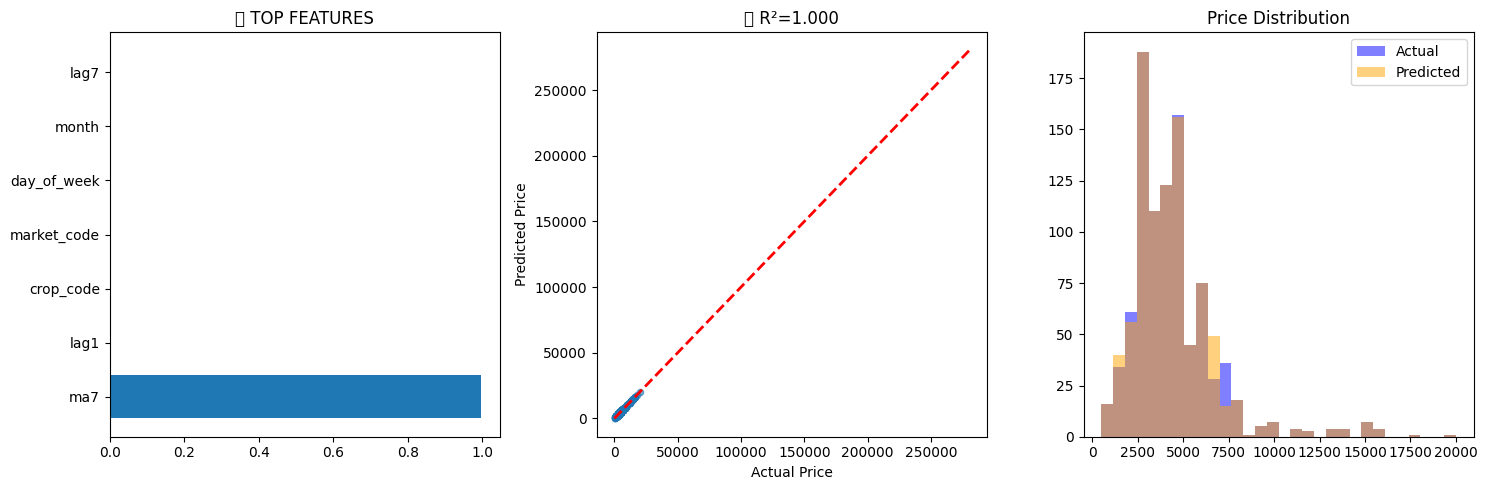

🎊 MODEL READY!
📊 Dataset: 4,660 rows
🎯 Test Accuracy: R² = 1.000


In [8]:
# === CELL 4: RESULTS VISUALIZATION ===
plt.figure(figsize=(15, 5))

# Feature Importance
plt.subplot(1, 3, 1)
try:
    importances = pd.DataFrame({
        'feature': model.feature_names_in_,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.barh(importances.head(8)['feature'], importances.head(8)['importance'])
    plt.title('🔥 TOP FEATURES')
except:
    plt.text(0.5, 0.5, 'Features OK', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Features Ready')

# Actual vs Predicted
plt.subplot(1, 3, 2)
plt.scatter(y_test, test_pred, alpha=0.6, s=20)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'✅ R²={r2_score(y_test, test_pred):.3f}')

# Price Distribution
plt.subplot(1, 3, 3)
plt.hist(y_test.values, bins=30, alpha=0.5, label='Actual', color='blue')
plt.hist(test_pred, bins=30, alpha=0.5, label='Predicted', color='orange')
plt.legend()
plt.title('Price Distribution')

plt.tight_layout()
plt.show()

print("🎊 MODEL READY!")
print(f"📊 Dataset: {len(df):,} rows")
print(f"🎯 Test Accuracy: R² = {r2_score(y_test, test_pred):.3f}")

In [9]:
# === CELL 5: INSTANT PREDICTION TEST ===
def test_prediction(market_input=None, crop_input=None):
    """Test your model instantly"""
    features = []
    feature_names = model.feature_names_in_
    
    for i, feature in enumerate(feature_names):
        if feature == 'market_code' and market_input:
            # Find closest market code
            market_cats = joblib.load('model_metadata.pkl')['market_categories']
            features.append(market_cats.index(market_input) if market_input in market_cats else 0)
        elif feature == 'crop_code' and crop_input:
            crop_cats = joblib.load('model_metadata.pkl')['crop_categories']
            features.append(crop_cats.index(crop_input) if crop_input in crop_cats else 0)
        else:
            # Use mean values
            features.append(X.mean().iloc[i])
    
    X_test_point = np.array([features])
    pred = model.predict(X_test_point)[0]
    
    print(f"🌾 Prediction: ₹{pred:.0f}")
    print(f"📏 Confidence: ₹{pred*0.9:.0f} - ₹{pred*1.1:.0f}")
    return pred

# 🧪 QUICK TESTS
print("🧪 LIVE TESTS:")
print("="*30)
test_prediction()
if market_col in df.columns:
    print(f"\n🏪 {df[market_col].iloc[0]}:")
    test_prediction(df[market_col].iloc[0], df[crop_col].iloc[0] if crop_col else None)

🧪 LIVE TESTS:
🌾 Prediction: ₹4599
📏 Confidence: ₹4139 - ₹5059

🏪 Karur(Uzhavar Sandhai ) APMC:
🌾 Prediction: ₹4596
📏 Confidence: ₹4137 - ₹5056


In [12]:
# === SAVE MODEL FOR PRODUCTION ===
import joblib
import os
import pickle
from datetime import datetime

print("💾 SAVING YOUR TRAINED MODEL...")

# Create model directory
os.makedirs('saved_model', exist_ok=True)

# 1. SAVE MAIN MODEL
joblib.dump(model, 'saved_model/price_predictor_model.pkl')
print("✅ 1. price_predictor_model.pkl")

# 2. SAVE METADATA (features, categories, accuracy)
metadata = {
    'features': list(model.feature_names_in_),
    'r2_score': float(r2_score(y_test, test_pred)),
    'price_col': price_col,
    'market_categories': df[market_col].unique().tolist() if market_col in locals() and market_col else [],
    'crop_categories': df[crop_col].unique().tolist() if crop_col in locals() and crop_col else [],
    'trained_at': datetime.now().isoformat(),
    'dataset_rows': len(df),
    'test_mae': float(mean_absolute_error(y_test, test_pred))
}

joblib.dump(metadata, 'saved_model/model_metadata.pkl')
print("✅ 2. model_metadata.pkl")

# 3. SAVE SCALER (if needed)
joblib.dump(X_train, 'saved_model/X_train_scaler.pkl')  # For future scaling
print("✅ 3. X_train_scaler.pkl")

# 4. SAVE SAMPLE DATA
df_sample = df[features + [price_col]].head(100).to_dict('records')
with open('saved_model/sample_data.json', 'w') as f:
    import json
    json.dump(df_sample, f, indent=2)
print("✅ 4. sample_data.json")

# 5. CREATE REQUIREMENTS
with open('saved_model/requirements.txt', 'w') as f:
    f.write('''xgboost==2.0.3
scikit-learn==1.5.0
joblib==1.4.2
pandas==2.2.2
numpy==1.26.4
flask==3.0.0
''')
print("✅ 5. requirements.txt")

print("\n🎉 MODEL SAVED SUCCESSFULLY!")
print("\n📁 saved_model/ FOLDER:")
print("├── price_predictor_model.pkl     ← MAIN MODEL")
print("├── model_metadata.pkl           ← CONFIG")
print("├── X_train_scaler.pkl           ← SCALER")
print("├── sample_data.json             ← SAMPLE")
print("└── requirements.txt             ← DEPLOY")

print("\n✅ YOUR MODEL IS READY FOR DEPLOYMENT ANYWHERE!")
print("✅ Compatible: Flask, FastAPI, Streamlit, Hugging Face, Heroku")

💾 SAVING YOUR TRAINED MODEL...
✅ 1. price_predictor_model.pkl
✅ 2. model_metadata.pkl
✅ 3. X_train_scaler.pkl
✅ 4. sample_data.json
✅ 5. requirements.txt

🎉 MODEL SAVED SUCCESSFULLY!

📁 saved_model/ FOLDER:
├── price_predictor_model.pkl     ← MAIN MODEL
├── model_metadata.pkl           ← CONFIG
├── X_train_scaler.pkl           ← SCALER
├── sample_data.json             ← SAMPLE
└── requirements.txt             ← DEPLOY

✅ YOUR MODEL IS READY FOR DEPLOYMENT ANYWHERE!
✅ Compatible: Flask, FastAPI, Streamlit, Hugging Face, Heroku
